# Modeling

*Justin R. Garrard*

### *Executive Summary*

This section represents the **Data Preparation** and **Modeling** sections of the CRISP-DM process.


### *Objectives*


1. **[Feature Selection]** To prototype the selection of features and data processing required before modeling.


2. **[Modeling]** To prototype various models (regression, correlation, clustering) as a means to better understand the data.



### Setup

In [80]:
# Import libraries
import os 
import math
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from ipywidgets import * 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [46]:
# Declare global variables
DATA_DIR = os.path.join('../data/processed')
DATA_FILE = os.path.join(DATA_DIR, 'processed.csv')
plt.style.use('ggplot')

CLUSTERING_COLS = ['leaid', 'year', 'lea_name', 'fips', 'number_of_schools', 
                  'teachers_total_fte', 'spec_ed_students', 
                  'enrollment_x',
                  'read_test_num_valid', 'read_test_pct_prof_midpt', 'math_test_num_valid',
                   'math_test_pct_prof_midpt', 'rev_total', 'exp_total']

## Set a target year for early analysis
TGT_YEAR = 2016

In [47]:
# Useful functions
def null_counter(df):
    record_nulls = []
    for col in df.columns:
        nulls = df[col].isnull().sum()
        percent_null = round((nulls / df.shape[0]) * 100, 2)
        record_nulls.append([col, nulls, percent_null])
    output = pd.DataFrame(record_nulls, columns=['Attribute', 'Null Count', '% Null'])
    return output

def get_year_range(df):
    year_range = list(df['year'].unique())
    year_range.sort()
    return year_range

def subset_by_states_only(df):
    df = df[df['fips'] <= 56]
    return df

def sound_off(df):
    nRow, nCol = cluster_df.shape
    print(f'There are {nRow} rows and {nCol} columns.')
    print('')

    YEAR_RANGE = get_year_range(cluster_df)
    print(f'Data spans the years {YEAR_RANGE[0]} to {YEAR_RANGE[-1]}.')
    print('')

    print('Available columns include:')
    display(null_counter(cluster_df))
    
def filter_out_factor(df, column_name):
    ## Identify records with null values in column
    bad_records = df[df[column_name].isnull()]
    bad_records.to_csv(f'missing_{column_name}.csv')

    ## Drop records with null values in column
    df = df[df[column_name].notnull()]
    return df

### Data Preparation

In this section we load the data, running various scripts to format the contents properly.

***High-Level Overview***

We tried to choose a subset of columns in which the data was mostly complete. That meant disqualifying rows that were:

* ... not states (i.e. territories).


* ... did not have reported scores for standardized tests.


* ... were outliers (three school districts with >500 schools).


* ... had flagged data (i.e. a "-2" value indicating that results could not be provided for privacy reasons)


We were especially disappointed to have to remove "english_language_learners" from the modeling data. In literature this factor is frequently referred to as significant. But, more than 6,000 records in our limited set simply have no reported value for this metric. Interpolation was briefly considered but is not likely to be an accurate approach.

**Normalization** was also performed in the last few cells. Given the large differences between districts with varying school counts, this was judged to be a necessary step.

In [48]:
# Load and preview data
## Isolate by specific columns
cluster_df = pd.read_csv(DATA_FILE)[CLUSTERING_COLS]
## Filter out non-state records
cluster_df = subset_by_states_only(cluster_df)
## Filter by year
cluster_df = cluster_df[cluster_df['year'] == TGT_YEAR]

sound_off(cluster_df)

/home/roy/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,9,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 18654 rows and 14 columns.

Data spans the years 2016 to 2016.

Available columns include:


,Attribute,Null Count,% Null
0,leaid,0,0.00
1,year,0,0.00
2,lea_name,0,0.00
3,fips,0,0.00
4,number_of_schools,0,0.00
5,teachers_total_fte,885,4.74
6,spec_ed_students,2238,12.00
7,enrollment_x,1383,7.41
8,read_test_num_valid,2374,12.73
9,read_test_pct_prof_midpt,2374,12.73


In [49]:
# Convert negative values (flags) to Null
for col in cluster_df.columns[3:]:
    cluster_df[col] = cluster_df[col].apply(lambda x: np.nan if x<0 else x)
               
# sound_off(cluster_df)

In [50]:
# Remove records with missing values
for col in cluster_df.columns:
    cluster_df = filter_out_factor(cluster_df, col)

sound_off(cluster_df)

There are 15490 rows and 14 columns.

Data spans the years 2016 to 2016.

Available columns include:


,Attribute,Null Count,% Null
0,leaid,0,0.0
1,year,0,0.0
2,lea_name,0,0.0
3,fips,0,0.0
4,number_of_schools,0,0.0
5,teachers_total_fte,0,0.0
6,spec_ed_students,0,0.0
7,enrollment_x,0,0.0
8,read_test_num_valid,0,0.0
9,read_test_pct_prof_midpt,0,0.0


,leaid,year,lea_name,fips,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total
97206,622710,2016,Los Angeles Unified,6.0,1012.0,28088.40,85751.0,633621.0,319838.0,40.0,322262.0,30.0,1.057872e+10,9.824700e+09
98197,1200390,2016,DADE,12.0,528.0,20884.00,35329.0,357249.0,212368.0,54.0,211532.0,56.0,3.679802e+09,3.785166e+09
98848,1709930,2016,City of Chicago SD 299,17.0,585.0,19016.08,51826.0,378199.0,184139.0,28.0,185465.0,24.0,5.840203e+09,5.827667e+09


(15490, 14)
(15487, 14)


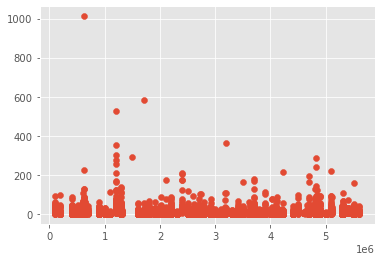

In [51]:
# Identify and remove outliers
plt.scatter(cluster_df['leaid'], cluster_df['number_of_schools'])

## Somewhat arbitrary threshold of >500 schools
outliers = cluster_df[cluster_df['number_of_schools'] > 500]
display(outliers)

print(cluster_df.shape)
cluster_df = cluster_df.drop(outliers.index)
print(cluster_df.shape)

In [52]:
# Remove the columns that won't be used as features
cluster_prepared_df = cluster_df.drop(['leaid', 'year', 'lea_name', 'fips'], axis=1)

### Correlation

The purpose of this section is to evaluate the linear relationships that the features have with one another.

***High-Level Overview***


* Intuitively, number of schools has a relationship with any metric directly dependent on quantity (revenue, expenditure, student counts, etc.) *We should consider creating ratio features as a means of better representing school distrcit behavior (i.e. special ed students per thousand enrolled).*


<AxesSubplot:>

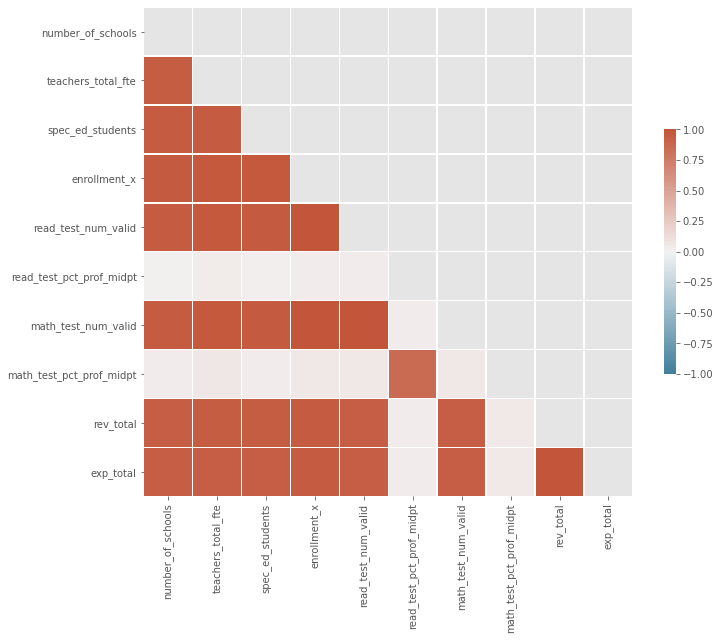

In [53]:
# Draw a correlation heatmap
## Uses Seaborn's documentation https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = cluster_prepared_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Regression

The purpose of this section is to regress the dataset on a single feature as a means of demonstrating a simple model. In this case, we've arbitrarily chosen math test proficiency midpoints.

***High-Level Overview***


* The following features don't meet the threshold for statistical significance for this particular regression: enrollment_x, read_test_num_valid, and exp_total. I suspect that's because each feature has other features which more-or-less capture their entire predictive power (i.e. read_test_num_valid ~ math_test_num_valid).


* Reading test results are the most influential feature by a large margin.

In [54]:
# Normalize data
features = cluster_prepared_df.drop('math_test_pct_prof_midpt', axis=1)
labels = cluster_prepared_df['math_test_pct_prof_midpt']

normed_features = preprocessing.StandardScaler().fit_transform(features)
normed_labels = preprocessing.StandardScaler().fit_transform(labels.to_numpy().reshape(-1,1))

In [55]:
# Setup a Linear Regression
lr_model = LinearRegression()

In [56]:
# Fit the regression with the available data
lr_model.fit(normed_features, normed_labels)
preds = lr_model.predict(normed_features)

In [57]:
# Visualize the resulting model
r_2 = round(lr_model.score(normed_features, normed_labels), 3)
print(f'R^2 Value: {r_2}')
print()

mse = round(mean_squared_error(normed_labels, preds), 3)
print(f'MSE: {mse}')
print()

coef_vals = [round(x,3) for x in lr_model.coef_[0]]
coef_map = list(zip(features.columns, coef_vals))
print(f'Coefficients:')
pprint.pprint(coef_map)
print()

print(f'Intercept: {lr_model.intercept_}')

# plt.scatter(normed_labels, preds, alpha=0.3)
# plt.plot()

R^2 Value: 0.753

MSE: 0.247

Coefficients:
[('number_of_schools', 0.074),
 ('teachers_total_fte', 0.148),
 ('spec_ed_students', -0.161),
 ('enrollment_x', 0.113),
 ('read_test_num_valid', 0.038),
 ('read_test_pct_prof_midpt', 0.862),
 ('math_test_num_valid', -0.109),
 ('rev_total', -0.146),
 ('exp_total', 0.066)]

Intercept: [2.48310645e-16]


In [58]:
# Use statsmodels to get more details
sm.OLS(normed_labels, normed_features).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.753
Method:                 Least Squares   F-statistic:                              5252.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):                        0.00
Time:                        11:09:19   Log-Likelihood:                         -11137.
No. Observations:               15487   AIC:                                  2.229e+04
Df Residuals:                   15478   BIC:                                  2.236e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0736      0.017      4.330      0.000       0.040       0.107
x2             0.1483      0.020      7.515      0.000       0.110       0.187
x3            -0.1608      0.019     -8.441      0.000      -0.198      -0.123
x4             0.1128      0.056      2.000      0.045       0.002       0.223
x5             0.0381      0.079      0.483      0.629      -0.117       0.193
x6             0.8624      0.004    214.137      0.000       0.854       0.870
x7            -0.1088      0.066     -1.650      0.099      -0.238       0.020
x8            -0.1458      0.047     -3.074      0.002      -0.239      -0.053
x9             0.0665      0.046      1.445      0.148      -0.024       0.157
==============================================================================
Omnibus:                      738.930   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2549.869
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       4.976   Cond. No.                         69.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Clustering

The purpose of this tool is specifically *descriptive* analytics. In short, we are looking to understand our underlying data, rather than build predictions. To that end, we try a few different setups to produce varying results. 


***High-Level Overview***

* An elbow chart of sum-of-squared-distances shows that a k value of 6 is well-suited for this clustering.


* The resulting cluster is fairly uneven in size (13,126, 133, 38, 1,969, 11, 492). I wonder if it would be meaningful to run a second clustering on the largest category?


* Clusterings seem to naturally correspond to number_of_schools. This seems reasonable, given that number_of_schools is going to influence most of the metrics used (enrollment, revenue, expenditure).

In [59]:
# Build an elbow chart to find a good cluster range
def build_elbow_chart(df, min_clusters=2, max_clusters=10, random_seed=777):
    ## Calculate sum of squared distances for each cluster
    ssd = []
    for k in range(min_clusters, max_clusters+1):
        kmeans_learner = KMeans(n_clusters=k, random_state=random_seed)
        kmeans_learner.fit(df)
        ssd.append(kmeans_learner.inertia_)

    ## Plot sum of squared distances
    plt.plot(range(min_clusters, max_clusters+1), ssd)
    plt.title('Elbow Chart')
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Distances')
    
    
# Build a good cluster and view the resulting data
def build_cluster(df, k=6, random_seed=777):
    kmeans_learner = KMeans(n_clusters=k, random_state=random_seed)
    results = kmeans_learner.fit_predict(df)
    return results


# View the characteristics of each labeled dataset
def view_cluster(df, results, k=6):
    df['labels'] = results
    for i in range(0, k):
        subset = df[df['labels'] == i]
        subset.to_csv(f'labeled_{i}.csv')
        print(i)
        display(subset.describe())
        print()

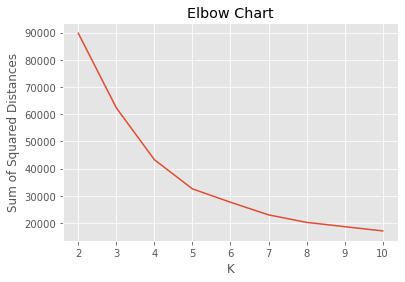

In [60]:
normed_data = pd.DataFrame(preprocessing.StandardScaler().fit_transform(cluster_prepared_df))

build_elbow_chart(normed_data)

In [61]:
results = build_cluster(normed_data, k=7)
view_cluster(cluster_prepared_df, results, k=7)

0


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4.063000e+03,4.063000e+03,4063.0
mean,3.754861,118.348041,223.159734,1762.794487,924.064484,73.040487,918.901551,72.200714,2.703033e+07,2.704725e+07,0.0
std,2.827550,120.218996,246.575636,1864.044806,986.485525,8.747576,982.729074,10.303543,3.085638e+07,3.161998e+07,0.0
min,0.000000,0.000000,3.000000,0.000000,6.000000,42.000000,6.000000,42.000000,1.090000e+05,1.530000e+05,0.0
25%,2.000000,34.065000,46.000000,459.500000,233.000000,67.000000,229.000000,64.500000,6.250500e+06,6.184500e+06,0.0
50%,3.000000,73.570000,123.000000,1035.000000,550.000000,72.000000,545.000000,72.000000,1.449300e+07,1.411700e+07,0.0
75%,5.000000,164.020000,315.500000,2433.500000,1278.500000,79.000000,1270.000000,80.000000,3.721900e+07,3.680350e+07,0.0
max,20.000000,737.880000,1516.000000,11609.000000,6325.000000,99.500000,6050.000000,99.500000,2.983710e+08,2.867010e+08,0.0



1


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,3.300000e+01,3.300000e+01,33.0
mean,138.212121,5851.147273,11595.363636,92920.121212,49282.272727,48.696970,49626.757576,47.242424,1.223059e+09,1.253212e+09,1.0
std,39.953690,1400.003452,2877.324830,22279.076703,12769.552927,19.073026,12935.015300,20.597376,3.298012e+08,3.300884e+08,0.0
min,67.000000,2941.590000,7043.000000,49085.000000,20631.000000,17.000000,20677.000000,15.000000,7.123200e+08,7.054150e+08,1.0
25%,111.000000,4951.200000,9699.000000,76428.000000,41323.000000,34.000000,39512.000000,29.000000,1.031020e+09,1.038807e+09,1.0
50%,126.000000,5750.250000,11484.000000,89345.000000,47334.000000,48.000000,50716.000000,46.000000,1.202380e+09,1.235828e+09,1.0
75%,168.000000,6822.500000,13530.000000,106145.000000,58509.000000,55.000000,58429.000000,57.000000,1.349412e+09,1.392542e+09,1.0
max,226.000000,9124.230000,18036.000000,147428.000000,78383.000000,87.000000,77907.000000,90.000000,2.264929e+09,2.247080e+09,1.0



2


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6020.000000,6.020000e+03,6.020000e+03,6020.0
mean,3.556977,91.717751,206.377076,1404.932226,725.669269,52.257309,723.843023,44.500748,2.050441e+07,2.035553e+07,2.0
std,2.866570,93.054662,226.144352,1494.748905,785.512045,8.465168,784.961309,9.228890,2.277061e+07,2.283371e+07,0.0
min,0.000000,0.000000,3.000000,0.000000,6.000000,22.000000,6.000000,10.000000,0.000000e+00,1.420000e+05,2.0
25%,1.000000,24.507500,45.000000,351.000000,172.000000,46.000000,172.000000,37.750000,4.889000e+06,4.742000e+06,2.0
50%,3.000000,58.470000,119.000000,839.000000,434.500000,52.000000,435.000000,44.500000,1.199800e+07,1.170600e+07,2.0
75%,5.000000,128.000000,289.000000,1921.250000,981.250000,58.000000,975.000000,51.000000,2.828650e+07,2.795900e+07,2.0
max,33.000000,494.600000,1441.000000,9578.000000,4642.000000,90.000000,4655.000000,77.000000,2.347710e+08,2.340920e+08,2.0



3


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,9.640000e+02,9.640000e+02,964.0
mean,20.889004,763.480021,1724.178423,13147.557054,6860.673237,52.514523,6863.477178,47.243776,1.794856e+08,1.794623e+08,3.0
std,8.877681,314.304978,707.648905,5317.721476,2902.090888,15.643510,2898.248224,17.485425,7.661055e+07,7.551638e+07,0.0
min,1.000000,0.000000,3.000000,360.000000,301.000000,8.000000,311.000000,7.000000,3.521600e+07,3.450400e+07,3.0
25%,15.000000,535.407500,1208.750000,9063.750000,4743.000000,41.000000,4715.500000,35.000000,1.222150e+08,1.221278e+08,3.0
50%,19.000000,689.705000,1559.000000,11543.500000,6093.000000,51.000000,6125.000000,46.000000,1.606390e+08,1.611880e+08,3.0
75%,26.000000,932.397500,2089.250000,15932.250000,8363.250000,64.000000,8411.250000,59.000000,2.217455e+08,2.223232e+08,3.0
max,78.000000,2114.300000,4680.000000,33255.000000,18230.000000,91.000000,18826.000000,94.000000,7.113750e+08,5.184680e+08,3.0



4


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,1.300000e+01,1.300000e+01,13.0
mean,256.230769,12477.367692,24114.076923,198555.076923,108511.692308,54.615385,111070.461538,53.769231,2.501097e+09,2.594611e+09,4.0
std,65.682511,2888.352563,7712.709667,51741.986131,30159.717133,11.273409,31007.063044,15.017511,5.702042e+08,6.173969e+08,0.0
min,137.000000,7951.870000,11846.000000,133929.000000,64640.000000,35.000000,66285.000000,20.000000,1.440668e+09,1.789123e+09,4.0
25%,217.000000,10709.300000,19375.000000,160467.000000,86055.000000,50.000000,84850.000000,50.000000,2.121511e+09,2.057207e+09,4.0
50%,257.000000,11781.660000,21822.000000,187467.000000,97818.000000,52.000000,109581.000000,54.000000,2.467450e+09,2.754874e+09,4.0
75%,290.000000,12698.040000,30089.000000,214386.000000,119711.000000,57.000000,121688.000000,58.000000,2.855683e+09,2.989364e+09,4.0
max,364.000000,18266.900000,38604.000000,326954.000000,170335.000000,84.000000,177021.000000,77.000000,3.359206e+09,3.680833e+09,4.0



5


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4.188000e+03,4.188000e+03,4188.0
mean,3.096705,69.128204,162.328319,1112.832617,573.756208,28.824260,576.355540,22.108286,1.588509e+07,1.570763e+07,5.0
std,2.864833,88.787874,214.890761,1460.091147,765.723597,9.659867,774.094396,9.241268,2.317029e+07,2.277794e+07,0.0
min,0.000000,0.000000,3.000000,0.000000,6.000000,2.000000,6.000000,0.500000,0.000000e+00,0.000000e+00,5.0
25%,1.000000,14.495000,33.000000,227.000000,109.000000,23.000000,109.000000,15.000000,3.019750e+06,2.935250e+06,5.0
50%,2.000000,34.000000,75.000000,506.500000,263.500000,30.000000,264.000000,23.000000,6.953500e+06,6.924000e+06,5.0
75%,4.000000,85.805000,196.000000,1371.250000,711.000000,36.000000,707.000000,29.000000,1.848350e+07,1.837450e+07,5.0
max,28.000000,551.400000,1703.000000,11066.000000,5390.000000,54.500000,5458.000000,52.000000,3.032020e+08,2.869870e+08,5.0



6


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,2.060000e+02,2.060000e+02,206.0
mean,58.985437,2335.050437,4967.844660,40051.757282,21234.213592,53.359223,21173.252427,51.631068,5.029261e+08,5.090343e+08,6.0
std,19.812654,872.789943,1697.543716,11930.592854,6760.688128,17.336190,6724.611978,20.620610,1.665515e+08,1.764807e+08,0.0
min,20.000000,0.000000,1847.000000,20309.000000,8960.000000,18.000000,8922.000000,10.000000,2.562470e+08,2.447770e+08,6.0
25%,44.000000,1785.417500,3718.250000,30779.000000,16069.000000,40.000000,16324.500000,35.000000,3.790285e+08,3.726318e+08,6.0
50%,54.000000,2176.865000,4592.000000,38109.000000,19764.000000,52.500000,19486.500000,50.500000,4.675765e+08,4.790430e+08,6.0
75%,70.000000,2769.735000,6002.000000,46863.750000,25123.000000,66.750000,25074.500000,70.000000,5.998815e+08,5.991560e+08,6.0
max,128.000000,5004.000000,10599.000000,78957.000000,41767.000000,91.000000,42491.000000,93.000000,1.180572e+09,1.144773e+09,6.0


[0.         0.58998974 1.17997947 1.76996921 2.35995894 2.94994868
 3.53993841 4.12992815 4.71991788 5.30990762 5.89989735]
[  27. 6710. 3950. 2930. 1079.  452.  218.   81.   26.   14.]


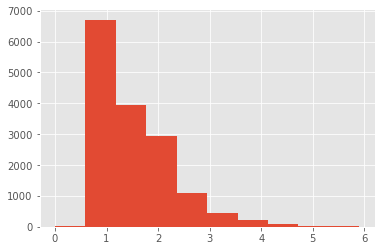

In [62]:
# Preview data for school count
x = plt.hist(cluster_prepared_df['number_of_schools'].apply(lambda x: math.log(x+1)))

print(x[1])
print(x[0])

[   1    2    4   10 1000]
[4046. 5072. 4472. 1870.]


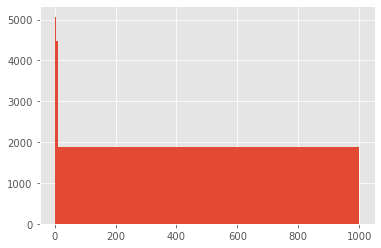

In [63]:
# Preview data for school count
x = plt.hist(cluster_prepared_df['number_of_schools'], 
         bins=[1,2,4,10,1000])

print(x[1])
print(x[0])

[ 0.          1.26975778  2.53951557  3.80927335  5.07903113  6.34878891
  7.6185467   8.88830448 10.15806226 11.42782004 12.69757783]
[   6.   15.  231. 1344. 4211. 5121. 3273. 1019.  239.   28.]


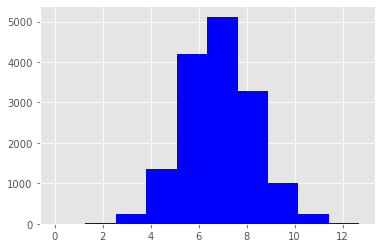

In [64]:
# Preview data for school count
x = plt.hist(cluster_prepared_df['enrollment_x'].apply(lambda x: math.log(x+1)),
         color='blue')

print(x[1])
print(x[0])

[     1    200    500   1000   2000   5000  10000  20000  50000 100000]
[2121. 3121. 2941. 2675. 2699. 1039.  502.  296.   62.]


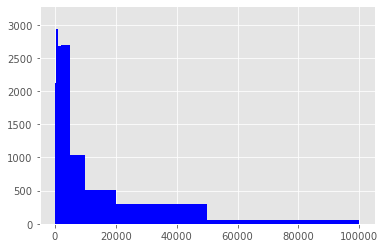

In [65]:
# Preview data for school count
x = plt.hist(cluster_prepared_df['enrollment_x'], 
         bins=[1,200,500,1000,2000,5000,10000,20000,50000,100000],
         color='blue')

print(x[1])
print(x[0])

In [66]:
# Place data into four categories, to prevent clustering from emphasizing size
single_df = cluster_prepared_df[cluster_prepared_df['number_of_schools'] == 1]

small_df = cluster_prepared_df[(cluster_prepared_df['number_of_schools'] > 1) & 
                               (cluster_prepared_df['number_of_schools'] <= 3)]

medium_df = cluster_prepared_df[(cluster_prepared_df['number_of_schools'] > 3) & 
                               (cluster_prepared_df['number_of_schools'] <= 10)]

large_df = cluster_prepared_df[(cluster_prepared_df['number_of_schools'] > 10)]

df_list = [single_df, small_df, medium_df, large_df]
counts = [x['number_of_schools'].count() for x in df_list]
print(counts)

[4046, 5072, 4708, 1634]


In [67]:
# Normalize within clusters to detect patterns besides size
normed_df_list = []
for df in df_list:
        normed_df_list.append(preprocessing.StandardScaler().fit_transform(df))

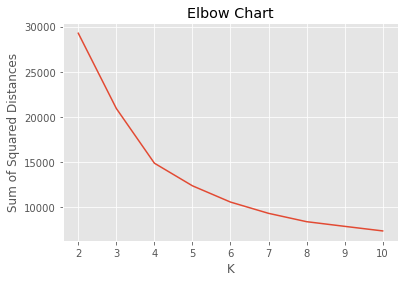

In [68]:
build_elbow_chart(normed_df_list[0])

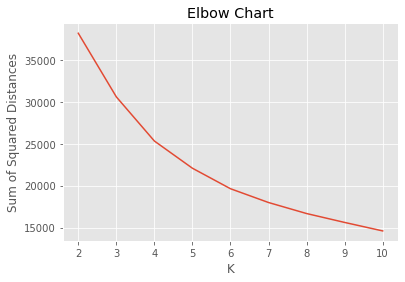

In [69]:
build_elbow_chart(normed_df_list[1])

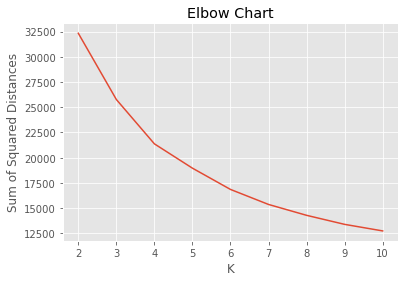

In [70]:
build_elbow_chart(normed_df_list[2])

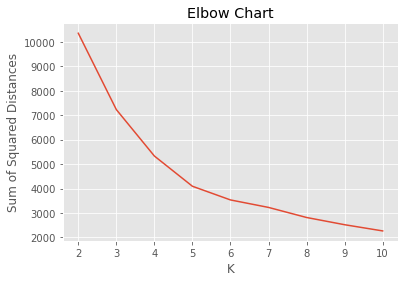

In [71]:
build_elbow_chart(normed_df_list[3])

In [72]:
results = []
for df in normed_df_list:
    results.append(build_cluster(df))

In [73]:
view_cluster(single_df, results[0])

0


<ipython-input-59-4316680a4fa7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = results


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,1476.0,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1.476000e+03,1.476000e+03,1476.0
mean,1.0,14.956762,39.276423,268.685637,134.526423,26.467480,134.242547,19.548780,3.583516e+06,3.537288e+06,0.0
std,0.0,12.408792,30.705040,191.325330,110.538374,10.833108,111.300720,9.886782,2.870639e+06,2.820039e+06,0.0
min,1.0,0.000000,3.000000,0.000000,6.000000,2.500000,6.000000,0.500000,0.000000e+00,0.000000e+00,0.0
25%,1.0,5.595000,16.000000,118.000000,45.000000,18.000000,44.750000,11.000000,1.539250e+06,1.538250e+06,0.0
50%,1.0,12.000000,31.000000,219.000000,105.000000,27.000000,105.000000,22.000000,2.798500e+06,2.727000e+06,0.0
75%,1.0,22.010000,54.000000,372.250000,194.000000,34.500000,193.250000,27.000000,4.734250e+06,4.722750e+06,0.0
max,1.0,65.010000,249.000000,1492.000000,572.000000,54.500000,573.000000,47.000000,2.144900e+07,2.131700e+07,0.0



1


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,808.0,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02,8.080000e+02,808.0
mean,1.0,19.363156,30.679455,312.185644,164.044554,75.518564,162.483911,72.205446,4.563672e+06,4.567900e+06,1.0
std,0.0,14.522016,26.917838,219.942333,133.891023,9.356675,132.735353,11.091397,3.487368e+06,3.633715e+06,0.0
min,1.0,0.000000,3.000000,0.000000,6.000000,49.500000,6.000000,42.000000,1.570000e+05,1.530000e+05,1.0
25%,1.0,8.997500,13.000000,142.000000,69.000000,69.500000,67.750000,64.500000,2.209750e+06,2.118750e+06,1.0
50%,1.0,17.425000,23.000000,259.000000,123.000000,74.500000,122.000000,72.000000,3.607000e+06,3.508500e+06,1.0
75%,1.0,28.000000,41.250000,446.250000,232.000000,82.000000,229.500000,77.000000,6.077250e+06,6.080250e+06,1.0
max,1.0,89.200000,196.000000,1230.000000,802.000000,99.500000,754.000000,99.500000,2.633000e+07,2.551400e+07,1.0



2


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,3.700000e+01,3.700000e+01,37.0
mean,1.0,164.103784,399.810811,2943.405405,1239.567568,53.540541,1215.189189,41.783784,5.463641e+07,5.362784e+07,2.0
std,0.0,71.601873,135.359981,834.109787,623.097974,18.619874,608.382867,20.519821,2.837458e+07,2.776518e+07,0.0
min,1.0,0.000000,171.000000,1688.000000,404.000000,16.000000,406.000000,7.000000,2.056300e+07,1.980700e+07,2.0
25%,1.0,124.950000,275.000000,2167.000000,765.000000,44.000000,776.000000,29.000000,3.242500e+07,3.059500e+07,2.0
50%,1.0,153.000000,414.000000,2789.000000,1268.000000,53.000000,1207.000000,37.000000,4.749800e+07,4.414000e+07,2.0
75%,1.0,209.000000,466.000000,3574.000000,1458.000000,64.000000,1430.000000,54.000000,7.143100e+07,6.861900e+07,2.0
max,1.0,299.500000,735.000000,4495.000000,2978.000000,93.000000,2939.000000,85.000000,1.386530e+08,1.291990e+08,2.0



3


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,441.0,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,4.410000e+02,4.410000e+02,441.0
mean,1.0,61.640385,134.913832,991.102041,496.786848,54.732426,491.358277,44.841270,1.581469e+07,1.556781e+07,3.0
std,0.0,26.592988,68.978006,391.735835,216.516459,17.350853,211.612045,19.139612,8.537605e+06,8.353045e+06,0.0
min,1.0,0.000000,11.000000,119.000000,31.000000,12.000000,31.000000,2.000000,3.420000e+05,7.160000e+05,3.0
25%,1.0,46.870000,86.000000,724.000000,351.000000,43.000000,353.000000,31.000000,9.488000e+06,9.563000e+06,3.0
50%,1.0,58.330000,118.000000,894.000000,475.000000,54.000000,471.000000,44.000000,1.342700e+07,1.313000e+07,3.0
75%,1.0,76.280000,166.000000,1199.000000,614.000000,64.000000,599.000000,57.000000,1.869800e+07,1.882800e+07,3.0
max,1.0,135.190000,469.000000,2947.000000,1284.000000,99.500000,1279.000000,98.000000,5.876900e+07,5.938000e+07,3.0



4


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,1278.0,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1.278000e+03,1.278000e+03,1278.0
mean,1.0,16.521487,33.578247,260.896714,136.570423,53.298905,136.221440,43.404930,3.800791e+06,3.750765e+06,4.0
std,0.0,11.496093,25.429000,175.549123,102.835810,9.890446,102.872793,10.074087,2.665769e+06,2.609849e+06,0.0
min,1.0,0.000000,3.000000,0.000000,6.000000,24.500000,6.000000,10.000000,0.000000e+00,1.420000e+05,4.0
25%,1.0,7.985000,15.000000,123.000000,57.250000,47.000000,57.000000,37.000000,1.850500e+06,1.821000e+06,4.0
50%,1.0,14.800000,27.000000,224.000000,109.000000,52.000000,108.000000,44.500000,3.141500e+06,3.135500e+06,4.0
75%,1.0,24.667500,47.000000,369.500000,196.000000,60.750000,195.000000,49.875000,5.136500e+06,5.057000e+06,4.0
max,1.0,57.000000,267.000000,1018.000000,605.000000,90.000000,605.000000,75.000000,1.813900e+07,1.608200e+07,4.0



5


,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,read_test_pct_prof_midpt,math_test_num_valid,math_test_pct_prof_midpt,rev_total,exp_total,labels
count,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000e+00,6.000000e+00,6.0
mean,1.0,341.583333,1866.666667,10196.666667,4784.500000,40.333333,4879.500000,23.50000,1.050422e+08,1.035592e+08,5.0
std,0.0,68.866840,497.799022,3249.941333,1169.489419,8.594572,1663.525623,10.48332,2.714475e+07,2.520812e+07,0.0
min,1.0,216.000000,1303.000000,5868.000000,3364.000000,29.000000,3372.000000,14.00000,6.799800e+07,6.608400e+07,5.0
25%,1.0,333.500000,1700.750000,8690.250000,4142.000000,35.000000,3938.750000,16.75000,8.640150e+07,8.834375e+07,5.0
50%,1.0,350.000000,1758.500000,9316.500000,4520.000000,39.500000,4282.500000,21.50000,1.079905e+08,1.074680e+08,5.0
75%,1.0,380.000000,1866.500000,12738.000000,5398.250000,46.250000,5246.500000,24.75000,1.219850e+08,1.219490e+08,5.0
max,1.0,415.500000,2796.000000,14319.000000,6596.000000,52.000000,7948.000000,43.00000,1.404190e+08,1.315900e+08,5.0


### Decision Tree


In [105]:
cluster_prepared_df['avg_midpoint'] = \
cluster_prepared_df[['read_test_pct_prof_midpt', 'math_test_pct_prof_midpt']].mean(axis=1)

features = cluster_prepared_df.drop(['math_test_pct_prof_midpt', 'read_test_pct_prof_midpt', 'avg_midpoint'], axis=1)
labels = cluster_prepared_df['avg_midpoint']

display(features.describe())

,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_num_valid,math_test_num_valid,rev_total,exp_total,labels
count,15487.000000,15487.000000,15487.000000,15487.000000,15487.000000,15487.000000,1.548700e+04,1.548700e+04,15487.000000
mean,5.799574,186.918489,401.015884,3025.308711,1585.252018,1586.136114,4.192481e+07,4.204594e+07,2.401563
std,13.080108,567.265265,1159.624464,9244.302209,4981.648402,5036.458084,1.194981e+08,1.224506e+08,1.898083
min,0.000000,0.000000,3.000000,0.000000,6.000000,6.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,24.010000,45.000000,349.000000,172.000000,172.000000,4.789000e+06,4.689000e+06,0.000000
50%,3.000000,61.960000,122.000000,894.000000,467.000000,466.000000,1.263800e+07,1.240800e+07,2.000000
75%,5.000000,160.270000,351.000000,2489.500000,1288.000000,1283.000000,3.600200e+07,3.569300e+07,5.000000
max,364.000000,18266.900000,38604.000000,326954.000000,170335.000000,177021.000000,3.359206e+09,3.680833e+09,6.000000


In [106]:
tree_model = DecisionTreeClassifier(random_state=777, max_depth=3)
discrete_labels = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(np.asarray(labels).reshape(-1, 1))
tree_model.fit(features, discrete_labels)

DecisionTreeClassifier(max_depth=3, random_state=777)

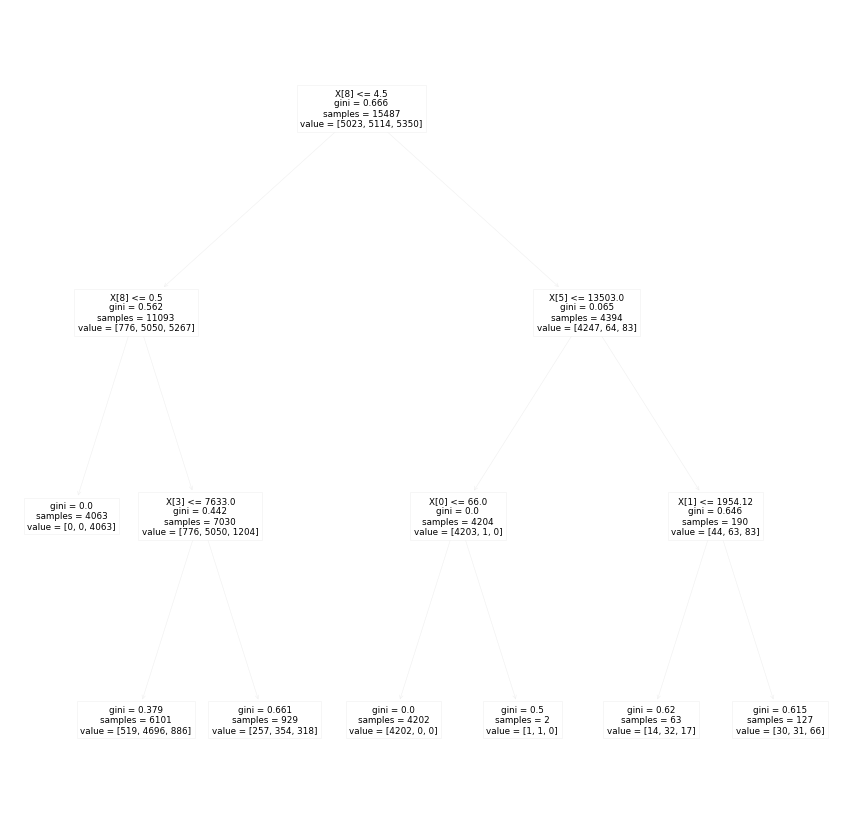

In [107]:
plt.figure(figsize=(15,15))
plot_tree(tree_model)
plt.show()

In [29]:
# # Build an elbow chart to find a good cluster range
# def build_elbow_chart(df):
#     ## Set parameters
#     min_clusters = 2
#     max_clusters = 10
#     random_seed = 777

#     ## Calculate sum of squared distances for each cluster
#     ssd = []
#     for k in range(min_clusters, max_clusters+1):
#         kmeans_learner = KMeans(n_clusters=k, random_state=random_seed)
#         kmeans_learner.fit(df)
#         ssd.append(kmeans_learner.inertia_)

#     ## Plot sum of squared distances
#     plt.plot(range(min_clusters, max_clusters+1), ssd)
#     plt.title('Elbow Chart')
#     plt.xlabel('K')
#     plt.ylabel('Sum of Squared Distances')
    
# build_elbow_chart(cluster_prepared_df)

In [30]:
# # Build a good cluster and view the resulting data
# def build_cluster(df):
#     chosen_k = 6
#     random_seed = 777
#     kmeans_learner = KMeans(n_clusters=chosen_k, random_state=random_seed)
#     results = kmeans_learner.fit_predict(df)
#     return results

# results = build_cluster(cluster_prepared_df)
    
# # Attach our new clustering labels to the original dataframe
# cluster_df['labels'] = results

In [31]:
# # View the characteristics of each labeled dataset
# def view_cluster(df, chosen_k=6):
#     for i in range(0, chosen_k):
#         subset = df[df['labels'] == i]
#         subset.to_csv(f'labeled_{i}.csv')
#         print(i)
#         display(subset.describe())
#         print()
        
# view_cluster(cluster_df)

In [32]:
# ## Try a second clustering on the largest category
# sub_cluster_df = cluster_prepared_df[cluster_df['labels'] == 0]
# build_elbow_chart(sub_cluster_df)


In [33]:
# results = build_cluster(sub_cluster_df)
# sub_cluster_df['labels'] = results

In [34]:
# view_cluster(sub_cluster_df)

In [35]:
# Output labeled data
cluster_df.to_csv('processed_labeled.csv')